In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2001,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [87]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
# portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
#                            ,classifier_list.NONE
#                           ,ranker_list.NONE)
# portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)
# portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
#                           ,classifier_list.WEEKLY_CRYPTO_FASTSLOW_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)
# portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
#                           ,classifier_list.WEEKLY_CRYPTO_FASTSLOW_CLASSIFIER
#                           ,ranker_list.WEEKLY_CRYPTO_FASTSLOW_RANKER)
# portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
# portfolios.append(portfolio_ii)
# portfolios.append(portfolio_iii)
# portfolios.append(portfolio_iv)
# portfolios.append(portfolio_v)
# portfolios.append(portfolio_vi)

In [88]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [89]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [90]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [119]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("qa_trades")
    trade["positions"] = int(portfolio.pricer_class.positions / 5)
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [120]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [121]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,...,classification,rank,short,risk,market_return,buy_day,sell_day,positions,portfolio,pricer_timeframe
0,2023,5,NVR,0.162122,1.0,0.977123,0.980057,0,0.980057,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
1,2023,6,CTLT,0.164171,1.0,0.985611,0.982816,0,0.982816,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
2,2023,7,NVR,0.186579,1.0,0.980140,0.987855,0,0.987855,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
3,2023,8,WST,0.068665,1.0,1.020477,1.033749,0,1.033749,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
4,2023,9,NVR,0.182605,1.0,1.013793,1.024996,0,1.024996,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,2023,18,K,0.023313,1.0,0.999298,0.989885,99,0.989885,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
1837,2023,19,AVGO,0.012836,1.0,1.034421,1.037073,99,1.037073,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
1838,2023,20,WMB,0.009255,1.0,1.020244,1.025480,99,1.025480,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week
1839,2023,21,PLD,0.007451,1.0,1.006233,1.008175,99,1.008175,True,...,False,False,False,True,1.15,1,5,20,wss_n_n_b_r,week


In [122]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [123]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [124]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'risk',
 'market_return',
 'buy_day',
 'sell_day',
 'portfolio',
 'pricer_timeframe']

In [125]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.31it/s]


In [126]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,risk,market_return,buy_day,sell_day,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
20,True,True,False,False,False,True,1.15,1,5,wss_n_n_b_r,week,0.925116,8.259263,1.701481,-0.009188


In [127]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,risk,market_return,buy_day,sell_day,pricer_timeframe,pv,beta,rrr,sharpe
0,wss_n_n_b_r,True,True,False,False,False,True,1.15,1,5,week,0.925116,8.259263,1.701481,-0.009188


In [128]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [145]:
ledger[ledger["week"]==25].head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
20,2023,25,AVGO,0.073706,1.0,0.977386,0,Information Technology,Broadcom Inc.
41,2023,25,NVDA,0.047305,1.0,0.955898,1,Information Technology,Nvidia
62,2023,25,BBY,0.036269,1.0,1.051890,2,Consumer Discretionary,Best Buy
83,2023,25,ODFL,0.026411,1.0,1.120583,3,Industrials,Old Dominion
104,2023,25,NTAP,0.023389,1.0,1.029521,4,Information Technology,NetApp
125,2023,25,CRM,0.022320,1.0,0.962437,5,Information Technology,Salesforce
146,2023,25,ADBE,0.022221,1.0,1.007018,6,Information Technology,Adobe Inc.
167,2023,25,AWK,0.022028,1.0,0.964688,7,Utilities,American Water Works
188,2023,25,TECH,0.019543,1.0,0.976237,8,Health Care,Bio-Techne
209,2023,25,CSCO,0.019537,1.0,0.986615,9,Information Technology,Cisco


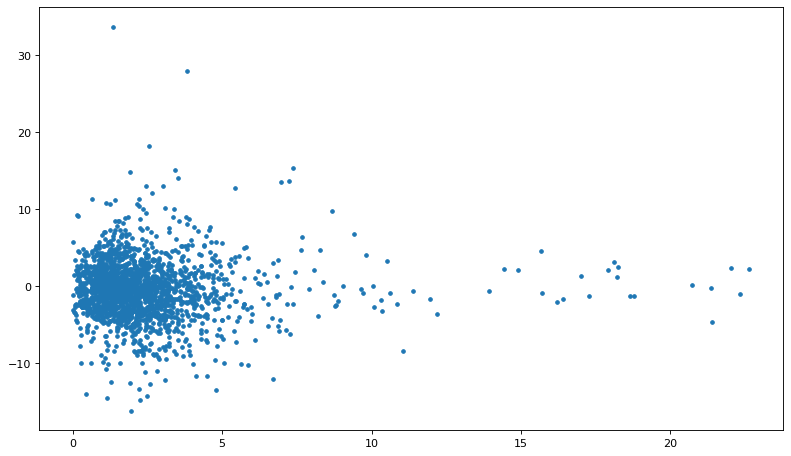

In [130]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [131]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2023,5,NVR,0.162122,1.0,0.980057,0,Consumer Discretionary,"NVR, Inc."
21,2023,5,BKNG,0.144232,1.0,1.021811,1,Consumer Discretionary,Booking Holdings
42,2023,5,AXP,0.080676,1.0,1.021551,2,Financials,American Express
63,2023,5,TSLA,0.072308,1.0,1.136185,3,Consumer Discretionary,"Tesla, Inc."
84,2023,5,LHX,0.067989,1.0,0.988874,4,Industrials,L3Harris
105,2023,5,BEN,0.067177,1.0,1.029487,5,Financials,Franklin Templeton
126,2023,5,CINF,0.054253,1.0,1.127883,6,Financials,Cincinnati Financial
147,2023,5,URI,0.054201,1.0,1.037260,7,Industrials,United Rentals
168,2023,5,WDC,0.047928,1.0,0.980205,8,Information Technology,Western Digital
189,2023,5,TDG,0.047317,1.0,1.034483,9,Industrials,TransDigm Group


In [132]:
ledger["actual_returns"].mean()

0.9958280477343402

In [133]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.4416078218359587

In [134]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [135]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,2023,5,0.980057,1.021811,1.021551,1.136185,0.988874,1.029487,1.127883,1.037260,...,0.978789,0.961630,1.043621,1.017125,1.007119,1.006200,0.978026,0.982120,1.040247,0.975574
1,2023,6,0.982816,0.991289,0.993511,1.063208,0.954529,0.962912,0.964579,0.960861,...,1.024540,0.978771,1.017751,0.942618,1.021115,0.991927,0.973068,1.018256,0.992009,0.982950
2,2023,7,0.987855,0.947752,0.963599,0.941797,0.935572,0.987417,0.883122,0.927290,...,0.971662,0.986969,0.962387,0.955818,0.962012,0.970272,0.991516,0.950272,0.953983,0.900638
3,2023,8,1.033749,0.977320,0.989334,0.981436,1.022704,0.974442,0.961192,0.975814,...,0.988226,0.976537,0.992512,0.996558,1.007451,0.953435,0.962048,0.964869,0.966619,1.000000
4,2023,9,1.024996,0.990930,1.003274,1.036043,1.009727,0.994033,0.992424,1.036143,...,1.011373,1.044714,0.975358,0.996160,0.956332,1.000000,1.000000,1.000000,1.000000,1.000000
5,2023,10,1.012970,0.958122,0.929852,0.988080,1.011693,0.985620,1.051542,0.997654,...,0.927956,0.934919,0.967640,0.907434,0.972297,0.991035,0.976578,0.910674,0.954641,0.955640
6,2023,11,1.020574,1.038556,1.007360,0.993027,1.004917,1.005765,1.005166,0.993108,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,2023,12,0.987472,0.985719,0.879293,1.019318,0.960167,0.995762,1.002775,0.983900,...,0.997447,0.957705,1.001151,0.989130,1.004445,0.954202,0.959825,0.946166,1.010464,1.027259
8,2023,13,1.020920,0.937587,1.049573,1.040158,1.017473,1.044433,1.004201,1.046188,...,1.037030,1.008442,0.990031,1.025885,1.013741,1.037949,1.020080,1.003735,1.043373,1.030233
9,2023,14,1.011473,0.977479,0.993867,0.928053,0.990295,1.056645,1.015863,0.984676,...,1.008531,1.043977,1.010408,1.003904,1.027718,0.860562,0.998282,1.016147,0.972914,0.945989


In [136]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [137]:
cumulative.head(50)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.980057,1.021811,1.021551,1.136185,0.988874,1.029487,1.127883,1.037260,0.980205,1.034483,...,0.992573,1.150641,0.978386,2023,5,1.040927,4036.79,1.000000,2023-W5,2023-02-03
1,0.963216,1.012910,1.014922,1.208001,0.943909,0.991306,1.087933,0.996663,1.004570,1.034964,...,0.990215,1.121151,0.952305,2023,6,1.026355,4105.96,1.017135,2023-W6,2023-02-10
2,0.951518,0.959987,0.977978,1.137692,0.883095,0.978832,0.960777,0.924196,0.984770,1.047813,...,0.907097,1.078281,0.933411,2023,7,0.984830,4112.98,1.018874,2023-W7,2023-02-17
3,0.983630,0.938215,0.967547,1.116572,0.903145,0.953815,0.923491,0.901843,0.955906,1.070351,...,0.892984,1.037321,0.883427,2023,8,0.965811,4118.10,1.020142,2023-W8,2023-02-24
4,1.008217,0.929705,0.970714,1.156816,0.911930,0.948124,0.916496,0.934438,1.018020,1.087046,...,0.885208,1.095372,0.898445,2023,9,0.977361,3992.69,0.989075,2023-W9,2023-03-03
5,1.021294,0.890771,0.902621,1.143027,0.922593,0.934490,0.963734,0.932246,1.016389,1.045002,...,0.831634,1.048338,0.899498,2023,10,0.951113,3986.15,0.987455,2023-W10,2023-03-10
6,1.042307,0.925115,0.909264,1.135057,0.927130,0.939877,0.968712,0.925821,1.029830,1.071229,...,0.822473,1.027275,0.916570,2023,11,0.958103,3961.34,0.981309,2023-W11,2023-03-17
7,1.029249,0.911903,0.799509,1.156984,0.890200,0.935894,0.971401,0.910915,0.990340,1.099024,...,0.786356,0.988585,0.932937,2023,12,0.938545,3908.78,0.968289,2023-W12,2023-03-24
8,1.050780,0.854989,0.839144,1.203446,0.905755,0.977478,0.975481,0.952988,1.032976,1.146745,...,0.814175,1.014734,0.957505,2023,13,0.961656,3962.22,0.981527,2023-W13,2023-03-31
9,1.062836,0.835734,0.833997,1.116862,0.896964,1.032847,0.990956,0.938385,1.003012,1.212226,...,0.803608,0.964027,0.900059,2023,14,0.952824,4027.35,0.997662,2023-W14,2023-04-07


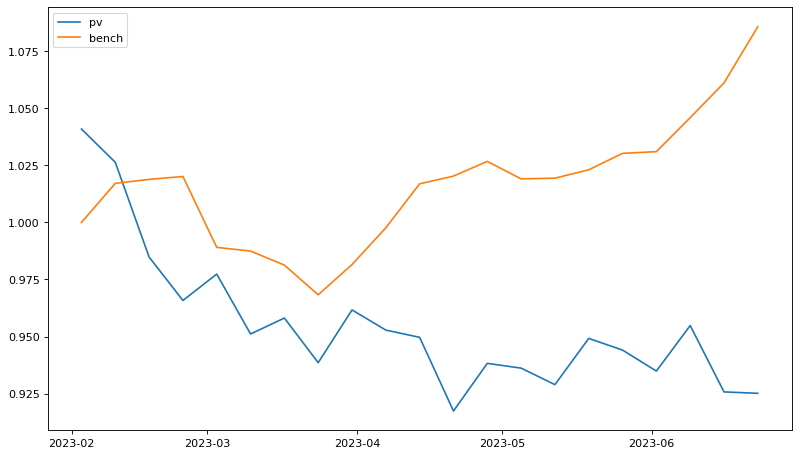

In [138]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [139]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.980057,1.021811,1.021551,1.136185,0.988874,1.029487,1.127883,1.037260,0.980205,1.034483,...,0.992573,1.150641,0.978386,2023,5,1.040927,4036.79,1.000000,2023-W5,2023-02-03
1,0.963216,1.012910,1.014922,1.208001,0.943909,0.991306,1.087933,0.996663,1.004570,1.034964,...,0.990215,1.121151,0.952305,2023,6,1.026355,4105.96,1.017135,2023-W6,2023-02-10
2,0.951518,0.959987,0.977978,1.137692,0.883095,0.978832,0.960777,0.924196,0.984770,1.047813,...,0.907097,1.078281,0.933411,2023,7,0.984830,4112.98,1.018874,2023-W7,2023-02-17
3,0.983630,0.938215,0.967547,1.116572,0.903145,0.953815,0.923491,0.901843,0.955906,1.070351,...,0.892984,1.037321,0.883427,2023,8,0.965811,4118.10,1.020142,2023-W8,2023-02-24
4,1.008217,0.929705,0.970714,1.156816,0.911930,0.948124,0.916496,0.934438,1.018020,1.087046,...,0.885208,1.095372,0.898445,2023,9,0.977361,3992.69,0.989075,2023-W9,2023-03-03
5,1.021294,0.890771,0.902621,1.143027,0.922593,0.934490,0.963734,0.932246,1.016389,1.045002,...,0.831634,1.048338,0.899498,2023,10,0.951113,3986.15,0.987455,2023-W10,2023-03-10
6,1.042307,0.925115,0.909264,1.135057,0.927130,0.939877,0.968712,0.925821,1.029830,1.071229,...,0.822473,1.027275,0.916570,2023,11,0.958103,3961.34,0.981309,2023-W11,2023-03-17
7,1.029249,0.911903,0.799509,1.156984,0.890200,0.935894,0.971401,0.910915,0.990340,1.099024,...,0.786356,0.988585,0.932937,2023,12,0.938545,3908.78,0.968289,2023-W12,2023-03-24
8,1.050780,0.854989,0.839144,1.203446,0.905755,0.977478,0.975481,0.952988,1.032976,1.146745,...,0.814175,1.014734,0.957505,2023,13,0.961656,3962.22,0.981527,2023-W13,2023-03-31
9,1.062836,0.835734,0.833997,1.116862,0.896964,1.032847,0.990956,0.938385,1.003012,1.212226,...,0.803608,0.964027,0.900059,2023,14,0.952824,4027.35,0.997662,2023-W14,2023-04-07


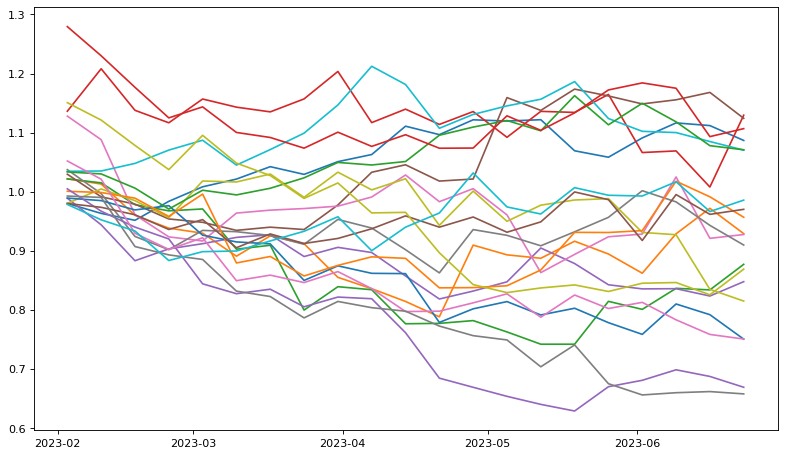

In [140]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [141]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Consumer Staples,2023.0,13.057554,0.017252,1.0,1.003434,51.287770
Industrials,2023.0,14.786713,0.020340,1.0,1.000510,52.003497
Consumer Discretionary,2023.0,14.774336,0.040745,1.0,0.999153,39.973451
Health Care,2023.0,13.473451,0.022792,1.0,0.998494,46.477876
Information Technology,2023.0,16.574684,0.026608,1.0,0.996018,40.192405
Real Estate,2023.0,15.302326,0.020745,1.0,0.995151,52.988372
Communication Services,2023.0,15.010870,0.026362,1.0,0.994596,37.934783
Materials,2023.0,12.958904,0.022363,1.0,0.994347,49.465753
Financials,2023.0,13.748718,0.021511,1.0,0.988234,50.769231


In [142]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year week ticker Security                                      
2023 5    CTLT   Catalent                           0.013525   
          ALGN   Align Technology                   0.038168   
     20   BBWI   Bath & Body Works, Inc.            0.025411   
     17   CMG    Chipotle Mexican Grill             0.073574   
     5    GWW    W. W. Grainger                     0.034117   
     20   EPAM   EPAM Systems                       0.019009   
     18   DVA    DaVita Inc.                        0.035182   
     5    TSLA   Tesla, Inc.                        0.072308   
     18   RCL    Royal Caribbean Group              0.069647   
     22   RCL    Royal Caribbean Group              0.030116   
     13   INTC   Intel                              0.024645   
     5    CINF   Cincinnati Financial               0.054253   
     25   ODFL   Old Dominion                       0.026411   
     19   GOOGL  Alphabet Inc. (Class A)            0.022252   
     6    MPWR   Monolithic Power Systems           0.006282   
     24   IPGP   IPG Photonics                      0.014134   
     17   TAP    Molson Coors Beverage Company      0.011246   
     7    WST    West Pharmaceutical Services       0.021639   
     23   ADBE   Adobe Inc.                         0.012362   
          DAL    Delta Air Lines                    0.022086   
     19   AKAM   Akamai                             0.030926   
     14   TECH   Bio-Techne                         0.023477   
     22   TSLA   Tesla, Inc.                        0.033716   
     21   TSLA   Tesla, Inc.                        0.086659   
     18   HST    Host Hotels & Resorts              0.024494   
     23   AAL    American Airlines Group            0.001393   
          NFLX   Netflix                            0.001853   
     19   WDC    Western Digital                    0.037920   
     23   ORCL   Oracle Corporation                 0.018380   
     18   BALL   Ball Corporation                   0.033430   

                                                weekly_delta_sign  \
year week ticker Security                                           
2023 5    CTLT   Catalent                                     1.0   
          ALGN   Align Technology                             1.0   
     20   BBWI   Bath & Body Works, Inc.                      1.0   
     17   CMG    Chipotle Mexican Grill                       1.0   
     5    GWW    W. W. Grainger                               1.0   
     20   EPAM   EPAM Systems                                 1.0   
     18   DVA    DaVita Inc.                                  1.0   
     5    TSLA   Tesla, Inc.                                  1.0   
     18   RCL    Royal Caribbean Group                        1.0   
     22   RCL    Royal Caribbean Group                        1.0   
     13   INTC   Intel                                        1.0   
     5    CINF   Cincinnati Financial                         1.0   
     25   ODFL   Old Dominion                                 1.0   
     19   GOOGL  Alphabet Inc. (Class A)                      1.0   
     6    MPWR   Monolithic Power Systems                     1.0   
     24   IPGP   IPG Photonics                                1.0   
     17   TAP    Molson Coors Beverage Company                1.0   
     7    WST    West Pharmaceutical Services                 1.0   
     23   ADBE   Adobe Inc.                                   1.0   
          DAL    Delta Air Lines                              1.0   
     19   AKAM   Akamai                                       1.0   
     14   TECH   Bio-Techne                                   1.0   
     22   TSLA   Tesla, Inc.                                  1.0   
     21   TSLA   Tesla, Inc.                                  1.0   
     18   HST    Host Hotels & Resorts                        1.0   
     23   AAL    American Airlines Group                      1.0   
          NFLX   Netflix                                      1.0  

In [143]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2023,5,0.979914,1.003131,1.004195,1.000000,1.010017,1.128769,1.027202,1.021249,0.975290,1.009196,0.984390
1,4092529,30,0.949945,0.991917,1.011180,1.000000,0.992485,1.106603,1.027445,1.026609,0.961605,1.011504,0.976837
2,8279186167,210,0.951533,0.965255,1.008157,0.913311,0.979575,1.078016,1.024432,0.977975,0.917354,0.973929,0.968205
3,16748793615841,1680,0.929964,0.966265,0.990505,0.913311,0.976180,1.042184,1.017080,0.954278,0.924197,0.950608,0.935553
4,33882809484846343,15120,0.882335,0.957085,0.977176,0.940239,0.933976,1.039066,1.026210,0.962791,0.921416,0.942627,0.956714
5,-5242052706994054575,151200,0.880915,0.901828,0.968185,0.886020,0.882381,1.036314,0.985395,0.937033,0.868580,0.918204,0.925497
6,2205216134019773975,1663200,0.880915,0.910123,0.980453,0.886020,0.882381,1.038625,0.988310,0.947636,0.902069,0.916394,0.925497
7,-2959826715708739647,19958400,0.863289,0.882950,0.994536,0.886020,0.857591,1.033256,0.991702,0.930123,0.914701,0.877596,0.918845
8,7462378076823969319,259459200,0.880092,0.901276,1.013641,0.899222,0.880318,1.063256,1.004330,0.963542,0.954343,0.912838,0.941022
9,6954197120476710449,3632428800,0.871811,0.889718,1.013742,0.899222,0.861814,1.087289,1.008915,0.943459,0.923863,0.935189,0.973017
